<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

## Tâche 2 : Analyse de sentiments, représentations des textes

*Import des librairies*

In [2]:
from os import listdir
from os.path import isfile, join
import re
import string

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import time
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import sklearn.naive_bayes as bayes
from sklearn import svm, linear_model as lin
from sklearn.model_selection import cross_val_score, StratifiedKFold

### Lecture de l'ensemble de revues étiquetées (positifs et négatifs).

In [4]:
posfiles = [f for f in listdir("./movies1000/pos") if isfile(join("./movies1000/pos", f))]
negfiles = [f for f in listdir("./movies1000/neg") if isfile(join("./movies1000/neg", f))]

pos = [open("./movies1000/pos/"+f).read() for f in posfiles]
lab_pos = [1 for _ in range(len(pos))]
neg = [open("./movies1000/neg/"+f).read() for f in negfiles]
lab_neg = [-1 for _ in range(len(neg))]

corpus = pos + neg
labels = np.array(lab_pos + lab_neg)

In [38]:
print("Nombre de revues (positives) :",str(len(lab_pos)))
print("Nombre de revues (negatives) :",str(len(lab_neg)))

Nombre de revues (positives) : 1000
Nombre de revues (negatives) : 1000


In [6]:
txt = pos[400]
print(txt)
print("-----")
print("NOMBRE DE TOKENS = ",len(txt.split()))

the happy bastard's 30-second review : 
american pie 
the summer of raunch continues to spread into theatres with this latest yuk fest , filled with sick jokes and teen dialogue aplenty . 
if you go expecting dawson's creek , you're in for a problem . 
if your expectations are lower ( and better , i might add ) , you will enjoy the hell out of american pie . 
the movie casts several unknowns , with the only real recognizable one being sctv's own eugene levy as a happy-go-lucky dad . 
the story revolves around four high school seniors who have one goal before the school year gets out- get laid . 
that's pretty much it . 
throughout the movie , little sick comic bits are sprinkled throughout , including a memorable scene involving an apple pie ( i won't give it away , but you probably know what it is ) and an internet broadcast gone horribly awry . 
of course , the movie has some slightly sentimental bits , but they don't drag the movie's humor content down that bad . 
most of the actors

### NLP Preprocessing Pipeline

On s'aperçoit que le texte possède des ponctuations, des caractères spéciaux 
La fonction de preprocessing qui permet de nettoyer et d'épurer une chaîne de caractères

#### [ETAPE 1] Text Normalization/Cleaning

In [7]:
def text_normalization(s):
    # source : http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3pp
    
    # elimination tabulations et retours à la ligne
    s = re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))
    # elimination des ponctuations
    punc = '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'
    s = s.translate(str.maketrans(punc, ' ' * len(punc)))
    # elimination des chiffres
    s = re.sub('\d+', '', s)
    # elimination des espaces multiples
    s = re.sub(' +', ' ', s)

    return s

In [8]:
step_1 = text_normalization(txt)
print(step_1)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_1.split()))

the happy bastard's second review american pie the summer of raunch continues to spread into theatres with this latest yuk fest filled with sick jokes and teen dialogue aplenty if you go expecting dawson's creek you're in for a problem if your expectations are lower and better i might add you will enjoy the hell out of american pie the movie casts several unknowns with the only real recognizable one being sctv's own eugene levy as a happy go lucky dad the story revolves around four high school seniors who have one goal before the school year gets out get laid that's pretty much it throughout the movie little sick comic bits are sprinkled throughout including a memorable scene involving an apple pie i won't give it away but you probably know what it is and an internet broadcast gone horribly awry of course the movie has some slightly sentimental bits but they don't drag the movie's humor content down that bad most of the actors get their job done but it's levy who's a hoot a father who 

#### [ETAPE 2] POS-Tagging

In [9]:
def display_postagging(s) :
    print(" ".join([w.pos_ for w in nlp(s)]))
    print("-----")
    displacy.render(nlp(s),style="ent",jupyter=True)

In [10]:
display_postagging(step_1)

DET PROPN PROPN PART ADJ NOUN ADJ NOUN DET NOUN ADP NOUN VERB PART VERB ADP NOUN ADP DET ADJ PROPN ADV VERB ADP ADJ NOUN CCONJ ADJ NOUN ADJ SCONJ PRON VERB VERB PROPN PART NOUN PRON AUX ADP ADP DET NOUN SCONJ DET NOUN AUX ADJ CCONJ ADJ PRON VERB VERB PRON VERB VERB DET NOUN SCONJ ADP ADJ NOUN DET NOUN VERB ADJ NOUN ADP DET ADJ ADJ ADJ NOUN AUX PROPN PART ADJ NOUN NOUN SCONJ DET ADJ NOUN ADJ NOUN DET NOUN VERB ADP NUM ADJ NOUN NOUN PRON AUX NUM NOUN ADP DET NOUN NOUN VERB ADP VERB VERB DET AUX ADV ADV PRON ADP DET NOUN ADJ ADJ ADJ NOUN AUX VERB ADP VERB DET ADJ NOUN VERB DET NOUN NOUN PRON VERB PART VERB PRON ADV CCONJ PRON ADV VERB PRON PRON AUX CCONJ DET NOUN NOUN VERB ADV ADV ADP NOUN DET NOUN AUX DET ADV ADJ NOUN CCONJ PRON AUX PART VERB DET NOUN PART NOUN NOUN ADP DET ADJ ADJ ADP DET NOUN VERB DET NOUN VERB CCONJ PRON AUX INTJ PRON AUX DET NOUN DET NOUN PRON VERB PART VERB NOUN ADP DET NOUN ADP DET NOUN ADP DET ADJ ADJ NOUN PRON VERB PART VERB VERB ADP DET NOUN CCONJ SCONJ PRON VER

On ne va garder que les **adjectifs, les adverbes, les noms et les verbes** car les autres catégories de POS-tag (ex : nom propre, déterminant, pronom..) n'ont aucune influence sur la polarité de la phrase

In [11]:
def filter_postagging(s):
    return " ".join([w.text for w in nlp(s) if w.pos_ in ['ADJ','ADV','NOUN','VERB']])

In [12]:
step_2 = filter_postagging(step_1) 
print(" ".join([w.pos_ for w in nlp(step_2) if w.pos_ in ['ADJ','ADV','NOUN','VERB']]))
print("-----")
print(step_2)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_2.split()))

ADJ ADJ NOUN NOUN NOUN VERB NOUN NOUN ADV ADV VERB ADJ NOUN NOUN NOUN ADJ VERB VERB ADJ NOUN NOUN ADV ADJ VERB VERB VERB VERB ADJ NOUN NOUN VERB ADJ NOUN ADV ADJ ADJ ADJ NOUN VERB VERB NOUN VERB ADJ NOUN NOUN NOUN NOUN NOUN VERB VERB ADV ADJ NOUN ADJ ADJ ADJ NOUN VERB VERB ADJ NOUN VERB NOUN NOUN VERB VERB ADV VERB NOUN NOUN VERB ADV ADJ NOUN NOUN ADV ADJ NOUN VERB NOUN NOUN NOUN ADJ ADJ NOUN VERB NOUN VERB VERB NOUN NOUN VERB ADJ ADJ NOUN VERB VERB VERB NOUN VERB VERB NOUN NOUN NOUN ADV ADJ NOUN ADJ NOUN VERB VERB VERB NOUN VERB NOUN ADV
-----
second review american pie summer raunch continues spread theatres latest fest filled sick jokes teen dialogue aplenty go expecting creek problem expectations lower better might add will enjoy hell american pie movie casts several unknowns only real recognizable one own eugene levy happy go lucky dad story revolves high school seniors goal school year gets get laid pretty much movie little sick comic bits sprinkled including memorable scene invo

#### [ETAPE 3a] Stemmatisation

La stemmatisation permet

Nous verrons son impact un peu plus tard dans la campagne d'évaluation

In [13]:
def stemmatisation(s):
    stemmer = SnowballStemmer('english',ignore_stopwords=True)
    words = s.split()
    words_stem = [stemmer.stem(w) for w in words]
    return " ".join(words_stem)

In [14]:
step_3a = stemmatisation(step_2)
print(step_3a)

second review american pie summer raunch continu spread theatr latest fest fill sick joke teen dialogu aplenti go expect creek problem expect lower better might add will enjoy hell american pie movi cast sever unknown only real recogniz one own eugen levi happi go lucki dad stori revolv high school senior goal school year get get laid pretti much movi littl sick comic bit sprinkl includ memor scene involv appl pie wo give away probabl know internet broadcast gone horribl awri cours movi slight sentiment bit drag movi humor content bad most actor get job done hoot father tri talk sex son help curious visual aid could stop laugh movi can stand raunch sex refer then american pie conserv type ll bet having fun home play theatr now


#### [ETAPE 3b]  Lemmatisation

La lemmatisation permet

Nous verrons son impact dans la campagne d'évaluation.

In [15]:
def lemmatisation(s):
    lemmas = [t.lemma_ for t in nlp(s)]
    return " ".join(lemmas)

In [16]:
step_3b = lemmatisation(step_2)
print(step_3b)

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty go expect creek problem expectation lower well may add will enjoy hell american pie movie cast several unknown only real recognizable one own eugene levy happy go lucky dad story revolve high school senior goal school year get get lay pretty much movie little sick comic bit sprinkle include memorable scene involve apple pie wo give away probably know internet broadcast go horribly awry course movie slightly sentimental bit drag movie humor content bad most actor get job do hoot father try talk sex son help curious visual aid could stop laugh movie can stand raunch sex reference then american pie conservative type will bet have fun home play theatre now


#### [ETAPE 4] Suppression des Stopwords

Pour l'analyse de sentiment, certains stopwords peuvent s'avérer être très important pour déterminer la polarité d'une phrase ou d'un texte. Comme par exemple "not", "no" etc...

Durant notre campagne d'évaluation, nous allons déterminer quel est le réel impact de ces stopwords.

In [17]:
def delete_stopwords(s,stopwords) :
    tokens = nlp(s)
    return " ".join([w.text for w in tokens if w.text not in stopwords])

In [18]:
print(stopwords.words('english'))
print("-----")
print(len(stopwords.words('english')),"STOPWORDS","[NLTK]")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
step_4 = delete_stopwords(step_3b,stopwords.words('english'))
print(step_4)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_4.split()))

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty go expect creek problem expectation lower well may add enjoy hell american pie movie cast several unknown real recognizable one eugene levy happy go lucky dad story revolve high school senior goal school year get get lay pretty much movie little sick comic bit sprinkle include memorable scene involve apple pie wo give away probably know internet broadcast go horribly awry course movie slightly sentimental bit drag movie humor content bad actor get job hoot father try talk sex son help curious visual aid could stop laugh movie stand raunch sex reference american pie conservative type bet fun home play theatre
-----
NOMBRE DE TOKENS =  118


In [20]:
print(STOP_WORDS)
print("-----")
print(len(STOP_WORDS),"STOPWORDS","[SPACY]")

{'from', "'re", 'where', 'this', 'anything', 'first', 'anywhere', 'meanwhile', 'beside', 'others', 'beyond', 'may', 'very', 'nothing', 'or', 'per', 'though', 'no', 'every', 'never', 'why', 'but', 'otherwise', 'eleven', 'twelve', 'yours', 'that', 'would', 'latterly', 'rather', 'out', 'afterwards', 'could', 'whom', 'wherever', 'if', 'ourselves', 'how', 'becoming', 'move', 'wherein', 'nobody', 'get', 'onto', 'of', 'own', 'due', 'last', 'part', 'being', 'elsewhere', 'once', 'as', 'everywhere', 'its', 'than', 'below', 'forty', '’d', 'down', 'them', 'we', 'becomes', "'ve", 'noone', 'the', 'hers', 'latter', 'whose', 'other', 'will', 'whether', 'four', 'hereupon', '‘m', 'who', 'were', 'either', 'using', 'whereas', 'somehow', 'hundred', 'anyway', 'within', 'bottom', 'on', 'around', '‘s', 'various', 'whereby', 'us', 'above', 'between', 'most', 'almost', 'are', 'two', 'yourselves', 'many', 'keep', 'hence', 'has', 'although', 'any', 'mine', 'whenever', 'make', 'yet', 'because', 'always', 'perhaps'

In [21]:
step_4 = delete_stopwords(step_3b, STOP_WORDS)
print(step_4)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_4.split()))

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty expect creek problem expectation lower add enjoy hell american pie movie cast unknown real recognizable eugene levy happy lucky dad story revolve high school senior goal school year lay pretty movie little sick comic bit sprinkle include memorable scene involve apple pie wo away probably know internet broadcast horribly awry course movie slightly sentimental bit drag movie humor content bad actor job hoot father try talk sex son help curious visual aid stop laugh movie stand raunch sex reference american pie conservative type bet fun home play theatre
-----
NOMBRE DE TOKENS =  105


In [22]:
fusion_stopwords = set(stopwords.words('english')).union(STOP_WORDS)
print(fusion_stopwords)
print("-----")
print(len(fusion_stopwords),"STOPWORDS","[NLTK+SPACY]")

{'from', 'wasn', "'re", 'namely', 'my', 'they', 'where', 'herein', 'this', 'didn', 'was', "couldn't", "mightn't", 'anything', 'first', 'anywhere', 'aren', 'now', 's', 'meanwhile', 'beside', 'others', 'had', 'give', 'beyond', 'here', 'without', 'hereafter', 'very', 'may', 'nothing', 'whence', 'ours', "it's", 'or', 'during', "n't", "that'll", 'up', 'per', 'though', 'until', 'isn', 'nowhere', '‘re', 'no', "didn't", 'also', "weren't", 'every', 'never', 'such', 'why', 'fifteen', 'these', 'together', 'but', 'm', 'otherwise', 'eleven', "'s", 'twelve', 'couldn', 'what', 'yours', 'and', 'that', 'would', "hasn't", 'shan', 'hasn', "needn't", 'latterly', 'seeming', "won't", 'be', 'one', 'thereafter', 'rather', 'do', 'out', "don't", 'you', 'not', 'something', 'well', 'afterwards', 'whom', "hadn't", 'could', 'put', 'wherever', 'if', "shan't", 'ourselves', 'how', 'becoming', 'so', 'your', 'in', 'move', 'several', 'about', "she's", 'by', 'off', 're', 'wherein', 'nobody', 'get', 'onto', 'of', 'whereaft

In [23]:
step_4 = delete_stopwords(step_3b, fusion_stopwords)
print(step_4)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_4.split()))

second review american pie summer raunch continue spread theatre latest fest fill sick joke teen dialogue aplenty expect creek problem expectation lower add enjoy hell american pie movie cast unknown real recognizable eugene levy happy lucky dad story revolve high school senior goal school year lay pretty movie little sick comic bit sprinkle include memorable scene involve apple pie wo away probably know internet broadcast horribly awry course movie slightly sentimental bit drag movie humor content bad actor job hoot father try talk sex son help curious visual aid stop laugh movie stand raunch sex reference american pie conservative type bet fun home play theatre
-----
NOMBRE DE TOKENS =  105


#### Pipeline du preprocessing

Cette fonction résume les différentes étape de la "pipeline" du preprocessing. Elle sera utilisée lors de la campagne d'évaluation.

In [55]:
def preprocessing(s,option,stopwords) :
    if option == "stema" :
        if stopwords :
            return delete_stopwords(stemmatisation(filter_postagging(text_normalization(s.lower()))),stopwords)
        else :
            return stemmatisation(filter_postagging(text_normalization(s.lower())))
    elif option == "lema" :
        if stopwords :
            return delete_stopwords(lemmatisation(filter_postagging(text_normalization(s.lower()))),stopwords)
        else :
            return lemmatisation(filter_postagging(text_normalization(s.lower())))
    else :
        if stopwords :
            return delete_stopwords(filter_postagging(text_normalization(s.lower())),stopwords)
        else :
            return filter_postagging(text_normalization(s.lower()))

### Exploration et analyse de la matrice Document-Term

#### Construction des différents corpus

In [25]:
# On garde les stopwords
corpus_ = [preprocessing(d,"none",None) for d in corpus]
corpus_lema = [preprocessing(d,"lema",None) for d in corpus]
corpus_stema = [preprocessing(d,"stema",None) for d in corpus]
# On supprime les stopwords
corpus_sw = [preprocessing(d,"none",fusion_stopwords) for d in corpus]
corpus_sw_lema = [preprocessing(d,"lema",fusion_stopwords) for d in corpus]
corpus_sw_stema = [preprocessing(d,"stema",fusion_stopwords) for d in corpus]

all_corpus = [[corpus_, corpus_lema, corpus_stema],
              [corpus_sw, corpus_sw_lema, corpus_sw_stema]]

#### [ETAPE 5] CountVectorizer

On va se concentrer sur le *corpus_sw_lema* pour explorer la matrice Document-Term et optimiser les différents hyper-paramètres des modèles qu'on va manipuler.

In [26]:
vectorizer = CountVectorizer(max_df = 0.85, min_df=0.002)
X = vectorizer.fit_transform(corpus_sw_lema)

In [27]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("30 mots du vocabulaire : ", vocab[5500:5530])

Nombre de mots dans le vocabulaire :  9921
30 mots du vocabulaire :  ['milestone' 'milieu' 'militant' 'military' 'militia' 'milk' 'mill'
 'millenium' 'millennium' 'miller' 'million' 'millionaire' 'mimic' 'mind'
 'minded' 'mindedness' 'mindless' 'mindset' 'mini' 'miniature' 'minimal'
 'minimalist' 'minimum' 'mining' 'minion' 'miniserie' 'minister' 'minnie'
 'minor' 'minority']


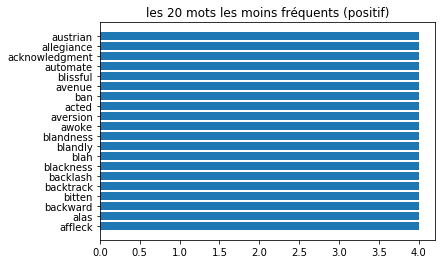

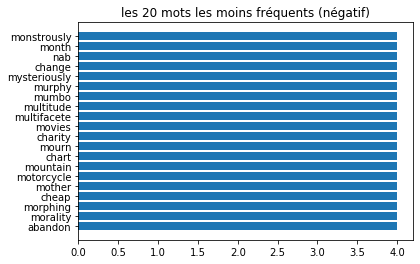

In [28]:
tf_pos = X.toarray().sum(0)[:1000]
tf_neg = X.toarray().sum(0)[1000:]

n = 20

ind_p = tf_pos.argsort()[:n]
ind_n = tf_neg.argsort()[:n]

plt.barh(vocab[ind_p], tf_pos[ind_p])
plt.title("les "+str(n)+" mots les moins fréquents (positif)")
plt.show()

plt.barh(vocab[ind_n], tf_neg[ind_n])
plt.title("les "+str(n)+" mots les moins fréquents (négatif)")
plt.show()

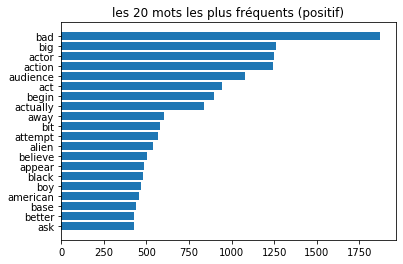

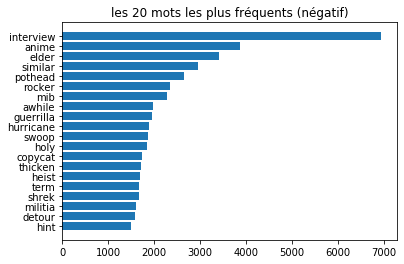

In [29]:
ind_p = tf_pos.argsort()[-n:]
ind_n = tf_neg.argsort()[-n:]

plt.barh(vocab[ind_p], tf_pos[ind_p])
plt.title("les "+str(n)+" mots les plus fréquents (positif)")
plt.show()

plt.barh(vocab[ind_n], tf_neg[ind_n])
plt.title("les "+str(n)+" mots les plus fréquents (négatif)")
plt.show()

### Optimisation des hyper-paramètres des modèles

In [48]:
def findBestHyperParam(name_clf, X_train, y_train,):
    if name_clf == "[reg_logistic]" :
        
        logistic = lin.LogisticRegression()

        param_grid = {'penalty':['l1', 'l2'],
                      'C':[0.1, 1, 10, 100],
                      'solver':['liblinear', 'saga'],
                      'max_iter': [5000]}

        grid = GridSearchCV(estimator=logistic,
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)

        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    
    elif name_clf == "[bayes]" :
        
        multi_nb = bayes.MultinomialNB()
        
        param_grid = {'alpha': [0,0.1,1,10,100]}
        
        grid = GridSearchCV(estimator=multi_nb,
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
        
    elif name_clf == "[svm]" :
        
        svc = svm.SVC()
        
        param_grid = {'C': [0.1, 1, 10, 100], 
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid']}
        
        grid = GridSearchCV(estimator=svc,
                            param_grid=param_grid,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    else :
        print("Le nom du modèle ne comvient pas pour cette fonction !")  

Recherche du meilleur du hyper-paramètre *Multinomial Naive Bayes* :
- alpha

In [31]:
best_multinb = findBestHyperParam("[bayes]", X, labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.8175000000000001
Best Params:  {'alpha': 1}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.2s finished


Recherche des meilleurs hyper-paramètres pour *SVM* :
- C
- kernel
- gamma

In [39]:
best_svm = findBestHyperParam("[svm]", X, labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.5min finished


Best Score:  0.8230000000000001
Best Params:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


Recherche des meilleurs hyper-paramètres pour *Régression Logistique* :
- C
- penality
- solver

In [49]:
best_reg_logistic = findBestHyperParam("[reg_logistic]", X, labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.6s


Best Score:  0.8309999999999998
Best Params:  {'C': 0.1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.5min finished


## Campagne d'évaluation et comparaison de 3 modèles de classification

Cette campagne d'évaluation va consister à choisir les meilleurs paramètres pour déterminer la classe d'un avis.

Les paramètres qui seront modulés :
- avec ou sans Stopwords
- Unigram/Bigram/Trigram
- Stemmatisation/Lemmatisation

In [33]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur, clf):

    tic = time.perf_counter() 
    
    ordinates = [[] for i in range(12)]
    abscissas = [[] for i in range(12)]
    cpt = 0

    for tab in corpus :
        for c in tab :
            abscissas[cpt] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            abscissas[cpt+1] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            for step in abscissas[cpt]:
                vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), max_df = 0.85, min_df=0.002)
                tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram), max_df = 0.85, min_df=0.002)
                X_v = vectorizer.fit_transform(c)
                X_t = tf_idf.fit_transform(c)
                ordinates[cpt].append(cross_validation(clf, X_v, labels))
                ordinates[cpt+1].append(cross_validation(clf, X_t, labels))
            cpt+=2
             
    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    
    labels = ['TF','TFIDF',
              'TF-LEMA','TFIDF-LEMA', 
              'TF-STEMA','TFIDF-STEMA',
              'TF-STPW','TFIDF-STPW',
              'TF-STPW-LEMA','TFIDF-STPW-LEMA',
              'TF-STPW-STEMA','TFIDF-STPW-STEMA']
    
    for j in range(12) :
        plt.plot(abscissas[j], ordinates[j], label=labels[j])
        plt.legend()
        
    plt.title(classifieur + " - Accuracy en fonction du nb de mots conservés : "+mot_gram(ngram))
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("Accuracy")
    plt.show()
    
    ind = [np.argmax(o) for o in ordinates]
    max_gram = [abscissas[_][ind[_]] for _ in range(12)] 

    for _ in range(12):
        print("Meilleur score <"+str(ordinates[_][ind[_]])+"> pour",labels[_],"avec "+(str(max_gram[_]))+" "+mot_gram(ngram))

    return max_gram

In [34]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test,y_test))
        
    return sum(scores)/n_splits

In [35]:
def get_len_vocab(corpus, ngram):
    vectorizer = CountVectorizer(ngram_range = (1,ngram))
    vectorizer.fit_transform(corpus)
    return len(vectorizer.get_feature_names())

In [36]:
def mot_gram(ngram):
    if ngram == 1:
        return "unigrams"
    elif ngram == 2:
        return "bigrams"
    elif ngram == 3:
        return "trigrams"
    else:
        return "ngrams"

### 1-Naive Bayes

UNIGRAM

Temps d'éxécution : 156.48 secondes


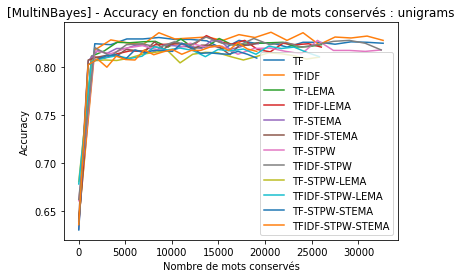

Meilleur score <0.8310000000000001> pour TF avec 8606 unigrams
Meilleur score <0.8365> pour TFIDF avec 20628 unigrams
Meilleur score <0.8300000000000001> pour TF-LEMA avec 15073 unigrams
Meilleur score <0.833> pour TFIDF-LEMA avec 13704 unigrams
Meilleur score <0.8275> pour TF-STEMA avec 14204 unigrams
Meilleur score <0.8265> pour TFIDF-STEMA avec 8125 unigrams
Meilleur score <0.828> pour TF-STPW avec 25615 unigrams
Meilleur score <0.8314999999999999> pour TFIDF-STPW avec 13670 unigrams
Meilleur score <0.8175000000000001> pour TF-STPW-LEMA avec 9522 unigrams
Meilleur score <0.8220000000000001> pour TFIDF-STPW-LEMA avec 20382 unigrams
Meilleur score <0.825> pour TF-STPW-STEMA avec 11068 unigrams
Meilleur score <0.8254999999999999> pour TFIDF-STPW-STEMA avec 17095 unigrams


In [37]:
bayes1 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 1, "[MultiNBayes]",best_multinb)

BIGRAM

Temps d'éxécution : 696.67 secondes


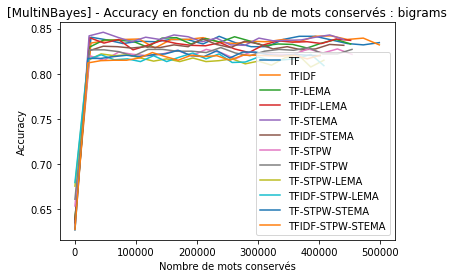

Meilleur score <0.8415000000000001> pour TF avec 367669 bigrams
Meilleur score <0.842> pour TFIDF avec 420190 bigrams
Meilleur score <0.841> pour TF-LEMA avec 261679 bigrams
Meilleur score <0.8400000000000001> pour TFIDF-LEMA avec 23807 bigrams
Meilleur score <0.8460000000000001> pour TF-STEMA avec 46410 bigrams
Meilleur score <0.8390000000000001> pour TFIDF-STEMA avec 208775 bigrams
Meilleur score <0.8275> pour TF-STPW avec 382494 bigrams
Meilleur score <0.8290000000000001> pour TFIDF-STPW avec 382494 bigrams
Meilleur score <0.8220000000000001> pour TF-STPW-LEMA avec 42974 bigrams
Meilleur score <0.8230000000000001> pour TFIDF-STPW-LEMA avec 193314 bigrams
Meilleur score <0.8260000000000002> pour TF-STPW-STEMA avec 169232 bigrams
Meilleur score <0.8234999999999999> pour TFIDF-STPW-STEMA avec 126929 bigrams


In [44]:
bayes2 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 2, "[MultiNBayes]",best_multinb)

### 2- SVM

UNIGRAM

Temps d'éxécution : 6150.07 secondes


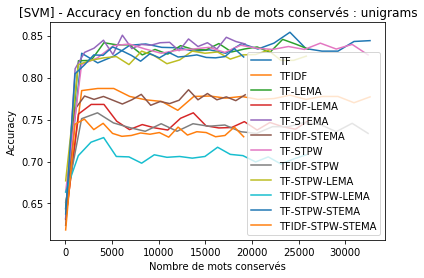

Meilleur score <0.8540000000000001> pour TF avec 24063 unigrams
Meilleur score <0.7870000000000001> pour TFIDF avec 3454 unigrams
Meilleur score <0.8455> pour TF-LEMA avec 23284 unigrams
Meilleur score <0.768> pour TFIDF-LEMA avec 2756 unigrams
Meilleur score <0.8505> pour TF-STEMA avec 6099 unigrams
Meilleur score <0.7855000000000001> pour TFIDF-STEMA avec 13191 unigrams
Meilleur score <0.841> pour TF-STPW avec 27321 unigrams
Meilleur score <0.758> pour TFIDF-STPW avec 3432 unigrams
Meilleur score <0.8324999999999999> pour TF-STPW-LEMA avec 21739 unigrams
Meilleur score <0.7285000000000001> pour TFIDF-STPW-LEMA avec 4092 unigrams
Meilleur score <0.8365> pour TF-STPW-STEMA avec 5042 unigrams
Meilleur score <0.7505> pour TFIDF-STPW-STEMA avec 2028 unigrams


In [52]:
svm1 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 1, "[SVM]",best_svm)

BIGRAM

In [ ]:
svm2 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 2, "[SVM]",best_svm)

### 3- Régression Logistique

UNIGRAM

Temps d'éxécution : 181.77 secondes


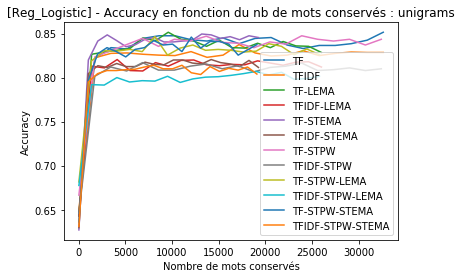

Meilleur score <0.8515> pour TF avec 32650 unigrams
Meilleur score <0.8375> pour TFIDF avec 17193 unigrams
Meilleur score <0.8514999999999999> pour TF-LEMA avec 9599 unigrams
Meilleur score <0.8204999999999998> pour TFIDF-LEMA avec 4125 unigrams
Meilleur score <0.8495000000000001> pour TF-STEMA avec 13191 unigrams
Meilleur score <0.8205> pour TFIDF-STEMA avec 14204 unigrams
Meilleur score <0.8474999999999999> pour TF-STPW avec 23909 unigrams
Meilleur score <0.817> pour TFIDF-STPW avec 6845 unigrams
Meilleur score <0.8465> pour TF-STPW-LEMA avec 8164 unigrams
Meilleur score <0.807> pour TFIDF-STPW-LEMA avec 19024 unigrams
Meilleur score <0.8460000000000001> pour TF-STPW-STEMA avec 12073 unigrams
Meilleur score <0.8140000000000001> pour TFIDF-STPW-STEMA avec 8055 unigrams


In [50]:
logistic1 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 1, "[Reg_Logistic]",best_reg_logistic)

BIGRAM

Temps d'éxécution : 641.81 secondes


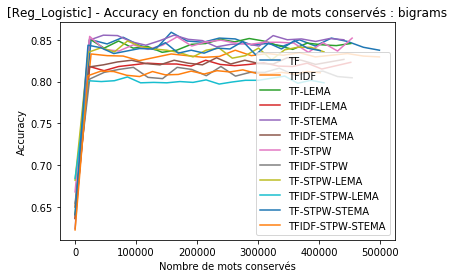

Meilleur score <0.859> pour TF avec 157584 bigrams
Meilleur score <0.8375> pour TFIDF avec 262626 bigrams
Meilleur score <0.8515> pour TF-LEMA avec 285467 bigrams
Meilleur score <0.8255000000000001> pour TFIDF-LEMA avec 214105 bigrams
Meilleur score <0.8554999999999999> pour TF-STEMA avec 46410 bigrams
Meilleur score <0.8285> pour TFIDF-STEMA avec 231970 bigrams
Meilleur score <0.8539999999999999> pour TF-STPW avec 23924 bigrams
Meilleur score <0.818> pour TFIDF-STPW avec 239066 bigrams
Meilleur score <0.8484999999999999> pour TF-STPW-LEMA avec 85928 bigrams
Meilleur score <0.8065> pour TFIDF-STPW-LEMA avec 343655 bigrams
Meilleur score <0.849> pour TF-STPW-STEMA avec 359595 bigrams
Meilleur score <0.8140000000000001> pour TFIDF-STPW-STEMA avec 274989 bigrams


In [51]:
logistic2 = campagne_evaluation(all_corpus, np.array(labels), fusion_stopwords, 2, "[Reg_Logistic]",best_reg_logistic)

## Génération des prédictions pour le dataset de test

Selon la campagne d'évaluation, ...

In [60]:
def generate_file_predict_test(predictions,nom_fichier) :
    filename = nom_fichier+".txt"
    
    with open(filename, "w") as f:
        for p in predictions :
            f.write("%s\n" % str(p))

In [56]:
corpus_test = [t.replace("<br /><br />"," ") for t in open("./testSentiment.txt", encoding="utf8").read().split("\n")]
corpus_test.pop()
print("Nombre de revues (test) :",str(len(corpus_test)))
print("-----")
print(corpus_test[0])

corpus_test_preprocess = [preprocessing(d,"none",None) for d in corpus_test]
print("-----")
print(corpus_test_preprocess[0])

Nombre de revues (test) : 25000
-----
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
-----
story man unnatural feelings pig starts opening scene terrific example absurd comedy formal orchestra audience turned insane violent mob crazy chantings singers unfortunately stays absurd whole time general narrative eventually making just too off putting even era should turned cryptic dialogue woul

On transforme le corpus de test en matrice sparse à partir des mots du vocabulaire contenus dans le vectorizer

In [61]:
best_vectorizer = CountVectorizer(max_features=logistic2[0], ngram_range=(1,2), max_df = 0.85, min_df=0.002)
X_train = best_vectorizer.fit_transform(corpus_)

best_reg_logistic.fit(X_train,labels)

X_test = best_vectorizer.transform(corpus_test_preprocess)
predictions = best_reg_logistic.predict(X_test)
generate_file_predict_test(predictions,"predictions_reglogistic_tf_bigram")

In [65]:
print("Number of positive in predictions :",np.sum(np.where(predictions == 1,1,0)))
print("Number of negative in predictions :",np.sum(np.where(predictions == -1,1,0)))

Number of positive in predictions : 11098
Number of negative in predictions : 13902


# Conclusion